In [1]:
# import python modules for processing the data
import echopype as ep
import echopype.visualize as epviz
import glob
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setup defaults
data_directory = r'C:\Users\marqjace\OneDrive - Oregon State University\Desktop\Python\azfp\data\may_2023\to_process'
output_directory = r'C:\Users\marqjace\OneDrive - Oregon State University\Desktop\Python\azfp\data\may_2023\processed'
#xml_file = 'glider_592_May2022/22052019.XML'
#xml_file = '59021_Azfp_temp_Coeffs.XML'
xml_file = 'tweaked.xml'

# generate a list of data files to process
file_list = glob.glob(os.path.join(data_directory, '*.01?'))
file_list.sort()

# make sure the data output directory exists
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)


In [3]:
# convert the list of .01X files using echopype and save the output as netCDF files
ed_list = []
for raw_file in file_list:
    # load the raw data into an xarray data set
    ed = ep.open_raw(raw_file, sonar_model='AZFP', xml_path=xml_file)
    
    # update some of the platform metadata
    ed.platform.attrs['platform_name'] = 'Glider 592'  # glider serial number
    ed.platform.attrs['platform_type'] = 'Sub-Surface Gliders'  # ICES platform type
    ed.platform.attrs['platform_code_ICES'] = '27'  # ICES code: sub-surface gliders 
                                                    # (buoyancy-based propulsion capable
                                                    # at variable depths not constrained 
                                                    # to be near sea surface)
                
    # change the Sv_offset values from NaN to 0's
    ed.vendor['Sv_offset'] = ed.vendor['DS'] * 0.0

    # save the converted data to a SONAR-netCDF4 data file
    ed.to_netcdf(os.path.join(output_directory, os.path.split(raw_file)[1] + '.raw.nc'))
    ed_list.append(ed)

# combine the data into a single dataset
ds = ep.combine_echodata(ed_list)

14:40:34  parsing file 23052418.01A with tweaked.xml, time of first ping: 2023-May-24 18:14:32
14:40:34  C:\Users\marqjace\OneDrive - Oregon State University\Desktop\Python\azfp\data\may_2023\to_process\23052418.01A has already been converted to netcdf4. File saving not executed.
14:40:34  parsing file 23052418.01B with tweaked.xml, time of first ping: 2023-May-24 18:23:26
14:40:34  C:\Users\marqjace\OneDrive - Oregon State University\Desktop\Python\azfp\data\may_2023\to_process\23052418.01B has already been converted to netcdf4. File saving not executed.
14:40:34  parsing file 23052418.01C with tweaked.xml, time of first ping: 2023-May-24 18:43:14
14:40:34  C:\Users\marqjace\OneDrive - Oregon State University\Desktop\Python\azfp\data\may_2023\to_process\23052418.01C has already been converted to netcdf4. File saving not executed.
14:40:34  parsing file 23052418.01D with tweaked.xml, time of first ping: 2023-May-24 18:51:57
14:40:35  C:\Users\marqjace\OneDrive - Oregon State University

In [4]:
ds

<EchoData: standardized raw data from C:\Users\marqjace\OneDrive - Oregon State University\Desktop\Python\azfp\data\may_2023\processed\23052418.01A.raw.nc>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter data (either complex samples or uncalibrated power samples) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

In [5]:
env_params = {
    'temperature': 10,
    'salinity': 34.0,
    'pressure': 1.0
}
ds_sv = ep.calibrate.compute_Sv(ds, env_params=env_params)
ds_sv

<xarray.Dataset>
Dimensions:                (channel: 3, ping_time: 20628, range_sample: 2633,
                            filenames: 1, time2: 20628)
Coordinates:
  * channel                (channel) <U11 '59021-67-1' ... '59021-200-3'
  * ping_time              (ping_time) datetime64[ns] 2023-06-02T00:26:53 ......
  * range_sample           (range_sample) int32 0 1 2 3 ... 2629 2630 2631 2632
  * time2                  (time2) datetime64[ns] 2023-06-02T00:26:53 ... 202...
Dimensions without coordinates: filenames
Data variables: (12/16)
    Sv                     (channel, ping_time, range_sample) float64 -96.54 ...
    echo_range             (channel, range_sample, ping_time) float64 0.1396 ...
    frequency_nominal      (channel) float64 6.7e+04 1.2e+05 2e+05
    temperature            int32 10
    salinity               float64 34.0
    pressure               float64 1.0
    ...                     ...
    TVR                    (channel) float64 160.8 168.2 168.0
    VTX                    (channel) float64 219.2 155.6 139.7
    equivalent_beam_angle  (channel, ping_time) float64 0.04831 ... 0.01209
    Sv_offset              (channel) float64 0.0 0.0 0.0
    source_filenames       (filenames) <U64 'D:\\gliders\\processing\\AZFP_Ch...
    water_level            (time2) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.6.0
    processing_time:              2023-08-23T07:23:51Z
    processing_function:          calibrate.compute_Sv

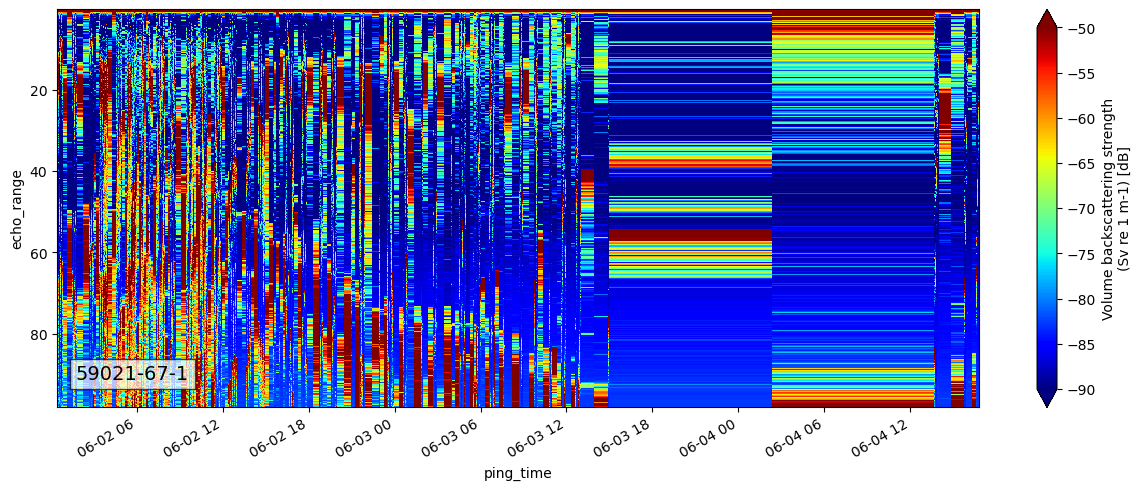

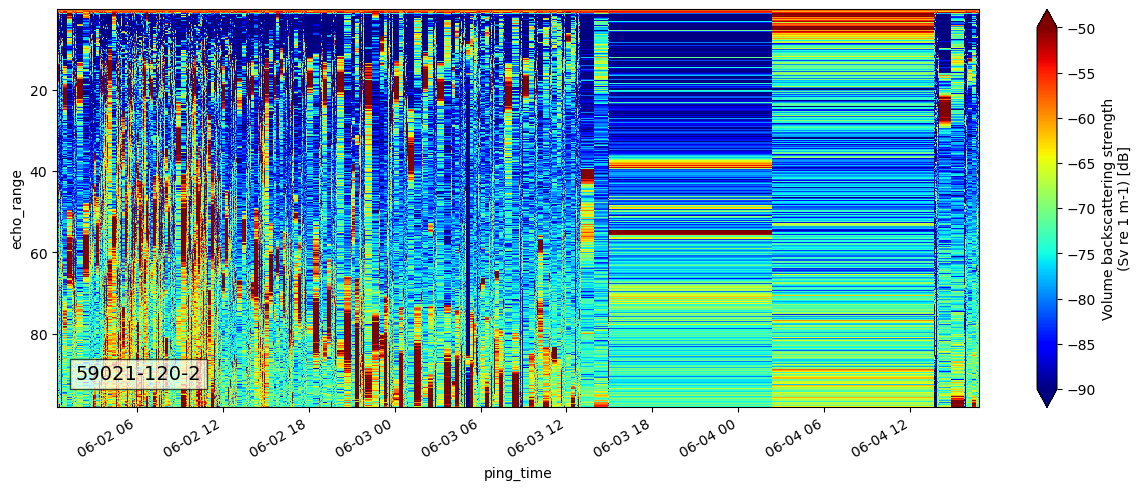

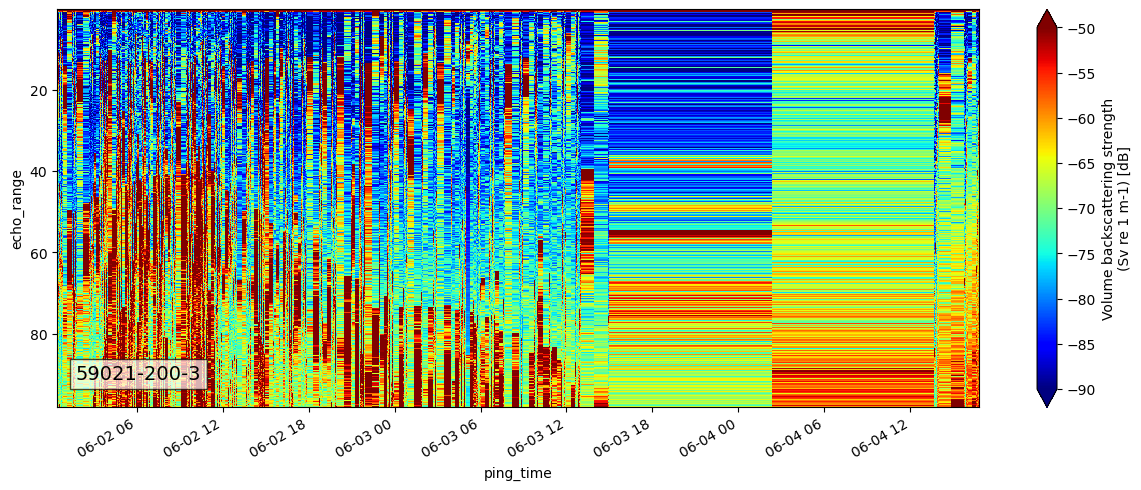

In [6]:
epviz.create_echogram(ds_sv, get_range=True, robust=True, vmin=-90, vmax=-50)

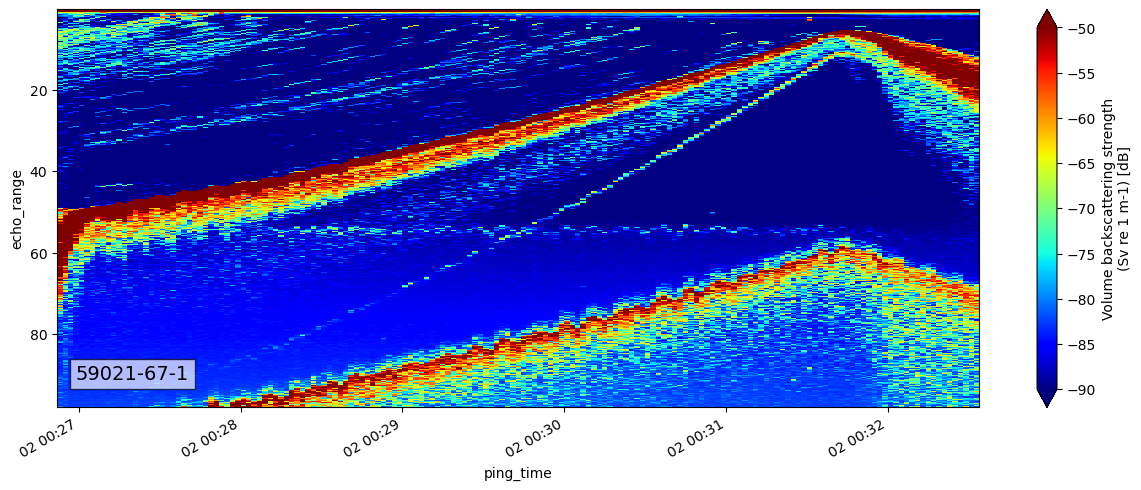

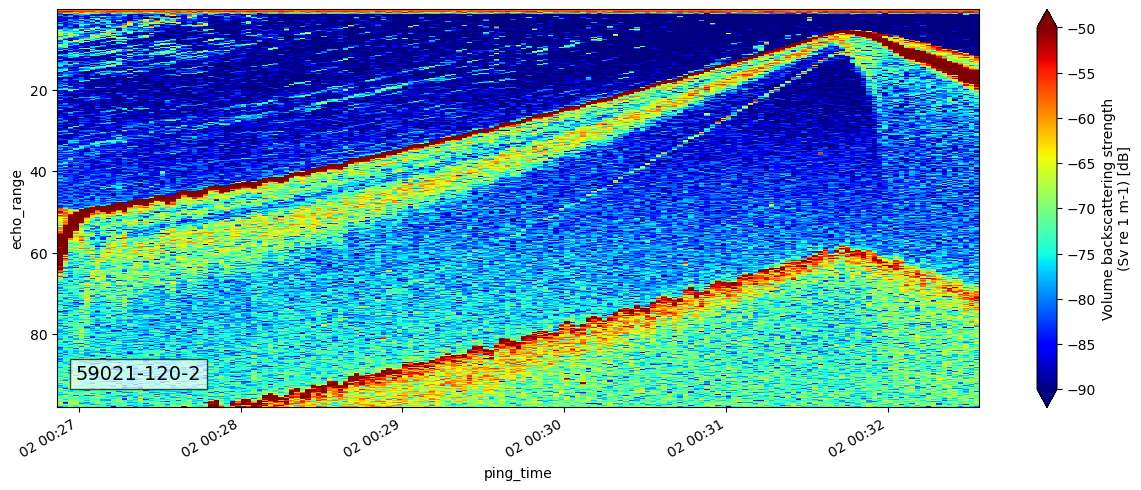

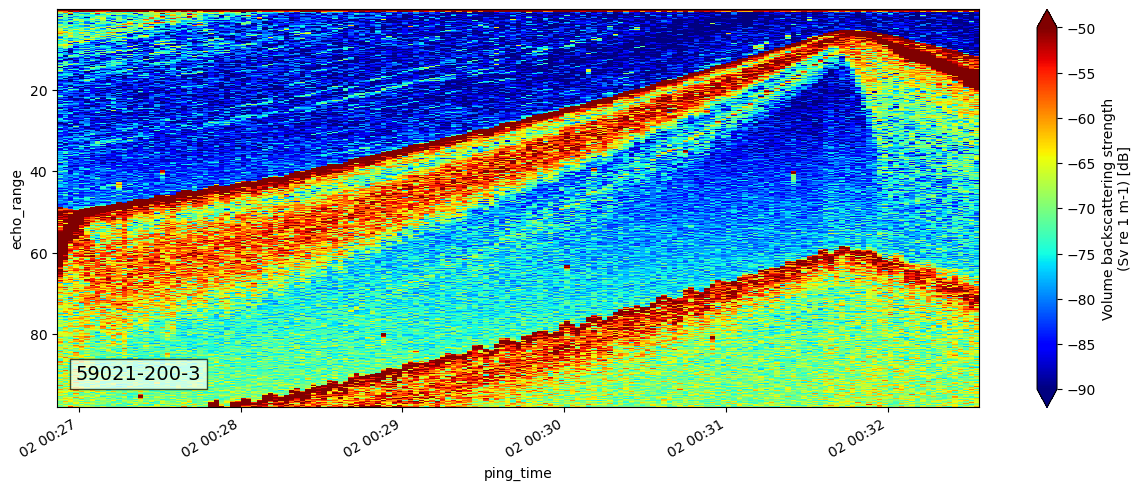

In [7]:
# look at just one of the files
ds_sv = ep.calibrate.compute_Sv(ed_list[0], env_params=env_params)
ds_sv_clean = ep.preprocess.remove_noise(ds_sv, range_sample_num=30, ping_num=5)
epviz.create_echogram(ds_sv_clean, get_range=True, robust=True, vmin=-90, vmax=-50)

In [8]:
# setup values that can be used to spoof a temperature and salinity values. would want to pull 
# this information from the glider CTD record if we were doing this processing for real.
temperature = np.array([15, 7])
salinity = np.array([32, 34])

# calculate Sv for each file and save the results per file to disk for further analysis
for ds in ed_list:
    time_record = np.array([ds.environment.time1.values[0], ds.environment.time1.values[-1]]).astype(float)
    t = np.interp(ds.environment.time1.values.astype(float), time_record, temperature)
    s = np.interp(ds.environment.time1.values.astype(float), time_record, salinity)
    env_params = {
        'pressure': 0.0,  # will always set to 0, replace after the fact
        'temperature': np.mean(t),
        'salinity': np.mean(s)
    }
    ds_sv = ep.calibrate.compute_Sv(ds, env_params=env_params)
    path, file = os.path.split(ds.provenance.source_filenames.values[0])
    ds_sv.to_netcdf(os.path.join(output_directory, file + '.proc.nc'))